In [47]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import timm
from torch.utils.data import Dataset, DataLoader
import cv2 as cv
from tqdm import tqdm
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from PIL import Image, ExifTags
import re

In [2]:
df_test = pd.read_csv("results_model.csv")

In [99]:
label2id = {value:index for index, value in enumerate(df_test['labels'].unique())}
id2label = {index:value for index, value in enumerate(df_test['labels'].unique())}

##### Выясним на каких классах низкие метрики

In [93]:
matrix = confusion_matrix(df_test['truths'], df_test['preds'])
# по диагонали кол-во классов верных деленное на кол-во каждого класса (то есть точность для каждого класса)
accuracy_each_class = matrix.diagonal() / matrix.sum(axis=1) 

In [94]:
# посмотрим на классы где метрика менее 0.8
bad_label = {label:acc for label, acc in zip(label2id.keys(), accuracy_each_class) if acc < 0.8}

In [95]:
bad_label

{'pork_chop': 0.72,
 'foie_gras': 0.684,
 'apple_pie': 0.668,
 'steak': 0.576,
 'bread_pudding': 0.708,
 'chocolate_cake': 0.764,
 'scallops': 0.792,
 'chicken_curry': 0.756,
 'ravioli': 0.772,
 'french_toast': 0.788,
 'ceviche': 0.788,
 'filet_mignon': 0.704,
 'chocolate_mousse': 0.712,
 'huevos_rancheros': 0.792,
 'cheesecake': 0.78,
 'ice_cream': 0.748,
 'omelette': 0.784}

Очень низкие метрики apple_pie, steak. Выясним причину.

Нарисуем матрицу сопряженности 

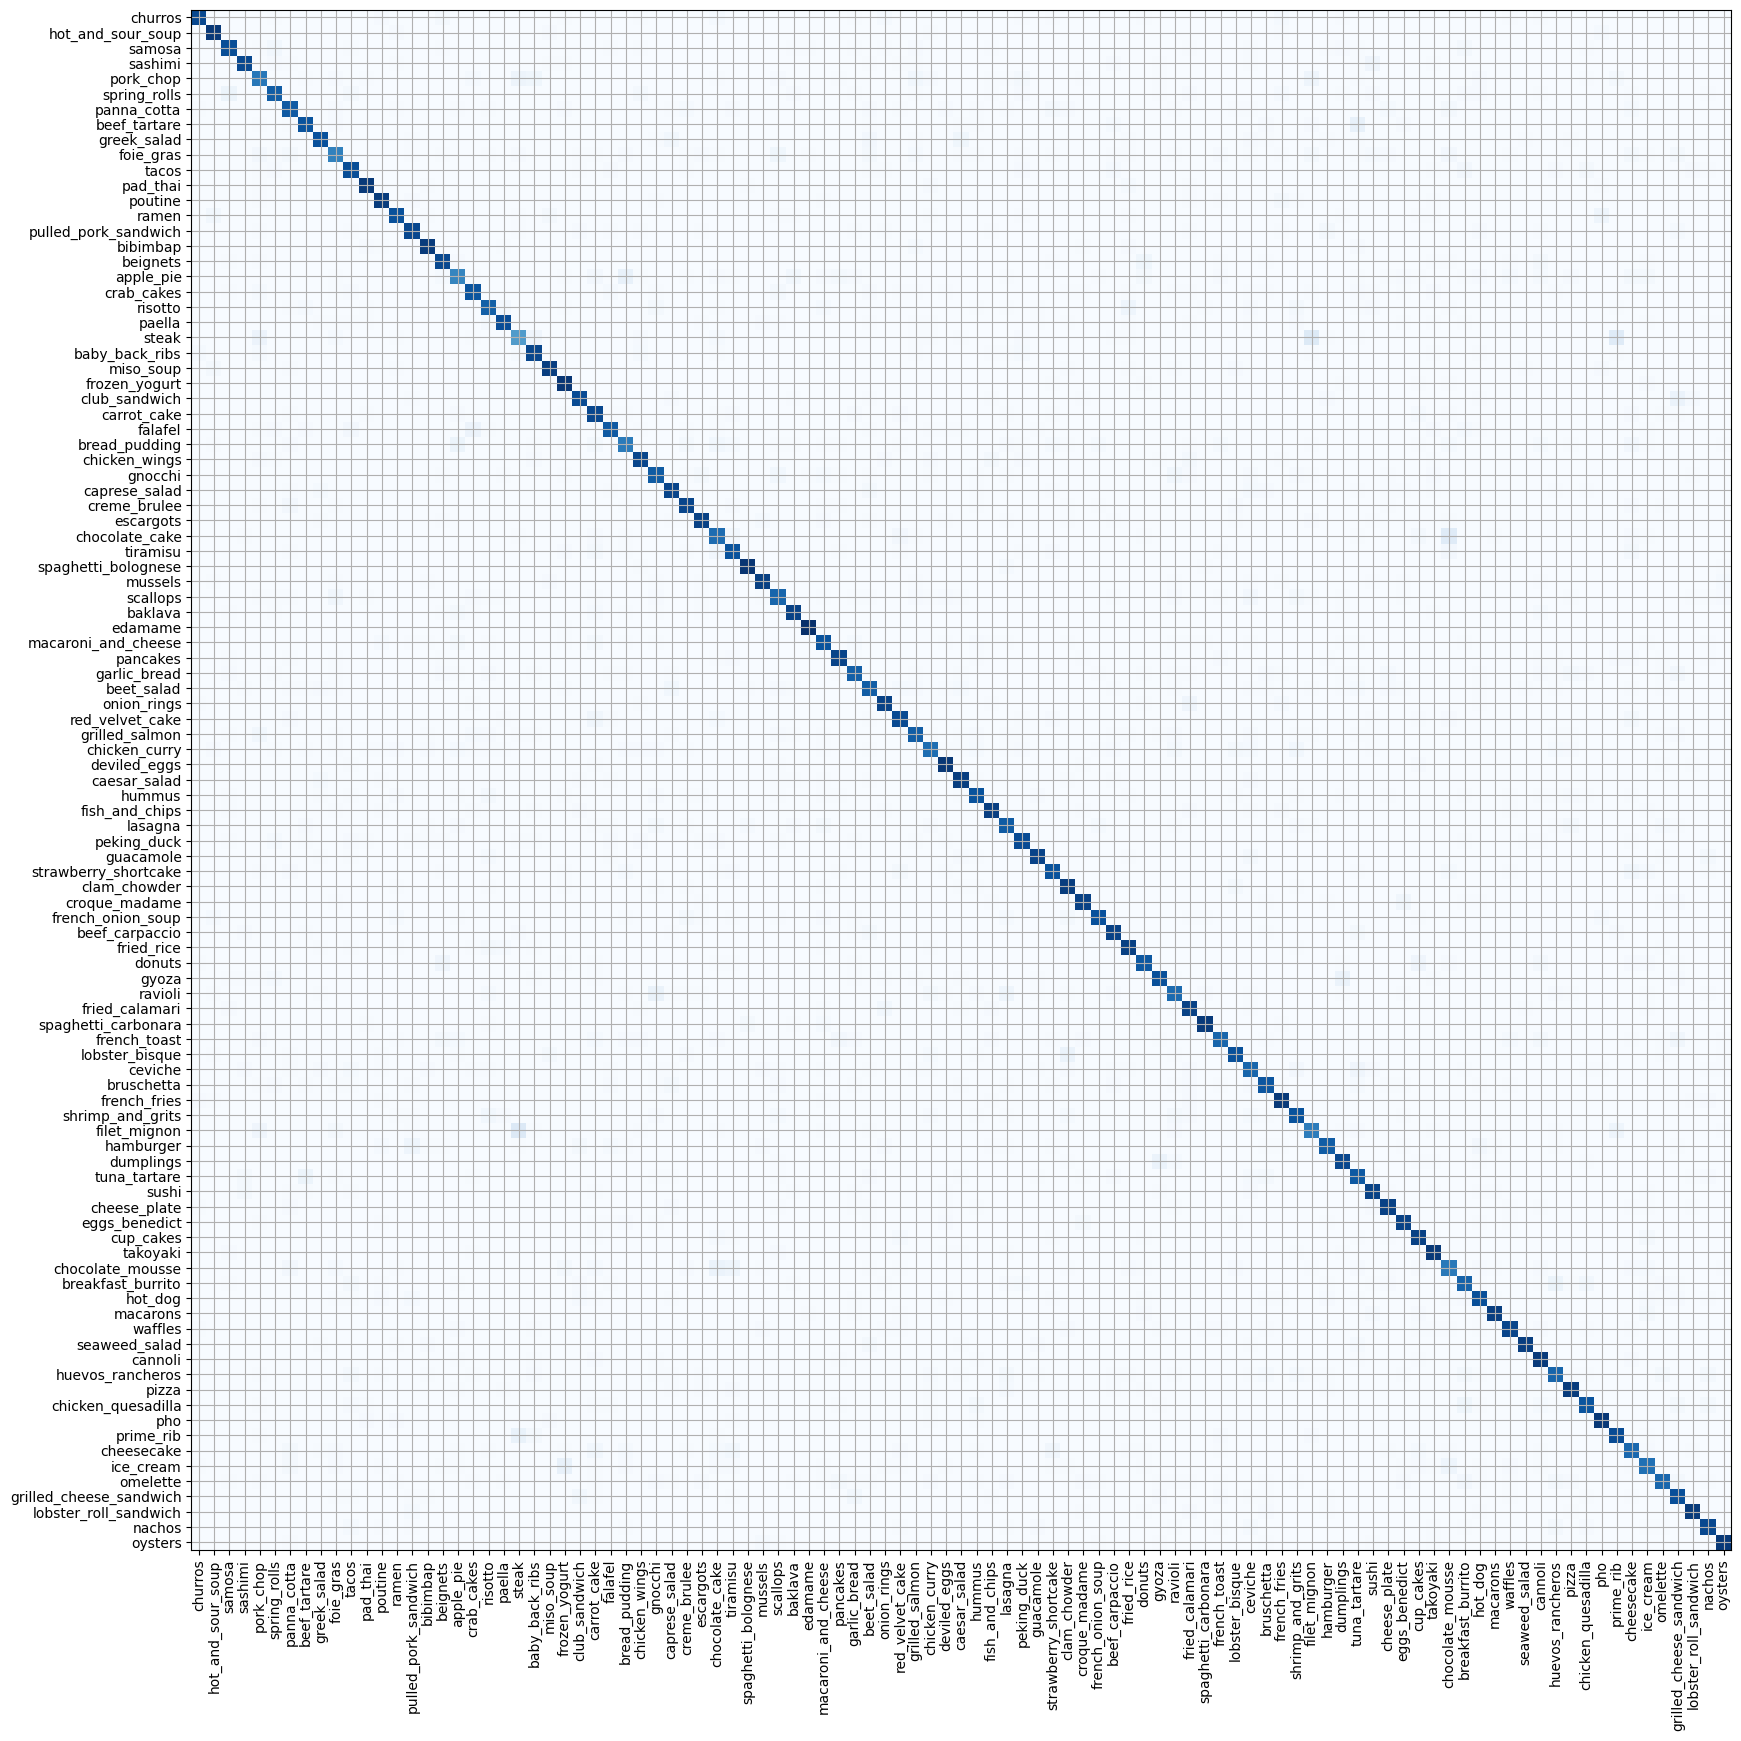

In [96]:
plt.figure(figsize=(20, 20))
plt.imshow(matrix, cmap=plt.cm.Blues)
plt.xticks(range(len(label2id)), label2id.keys(), rotation=90)
plt.yticks(range(len(label2id)), label2id.keys())
plt.grid()
plt.show()

в данном случае не особо информативно (много классов), рассмотрим построчно

In [104]:
matrix[label2id['steak']]

array([  0,   0,   0,   0,  14,   0,   0,   0,   0,   3,   0,   0,   0,
         1,   0,   0,   0,   0,   1,   0,   0, 144,  10,   0,   0,   0,
         0,   0,   0,   2,   0,   0,   0,   0,   3,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   1,   1,   0,   1,   0,
         0,   0,   2,   0,   0,   0,   0,   0,   1,   1,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,  33,   1,   0,   1,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,  30,   0,   0,   0,   0,   0,   0,   0])

In [111]:
id2label[np.where(matrix[label2id['steak']]==33)[0][0]]

'filet_mignon'

Модель при steak чаще всего ошибочно прогнозирует filet_mignon

Посмотрим на картинки 

In [112]:
def draw_img_food(label_food: str):
    plt.figure(figsize=(15,5))
    plt.suptitle(f"Примеры картинок для: {label_food}")
    samples_path_images = df_test.query(f"labels=='{label_food}'")['paths'].sample(10)
    for num, path in enumerate(samples_path_images):
        plt.subplot(2,5,num+1)
        img = Image.open(f"images/{path}.jpg")
        plt.axis("off")
        plt.imshow(img)

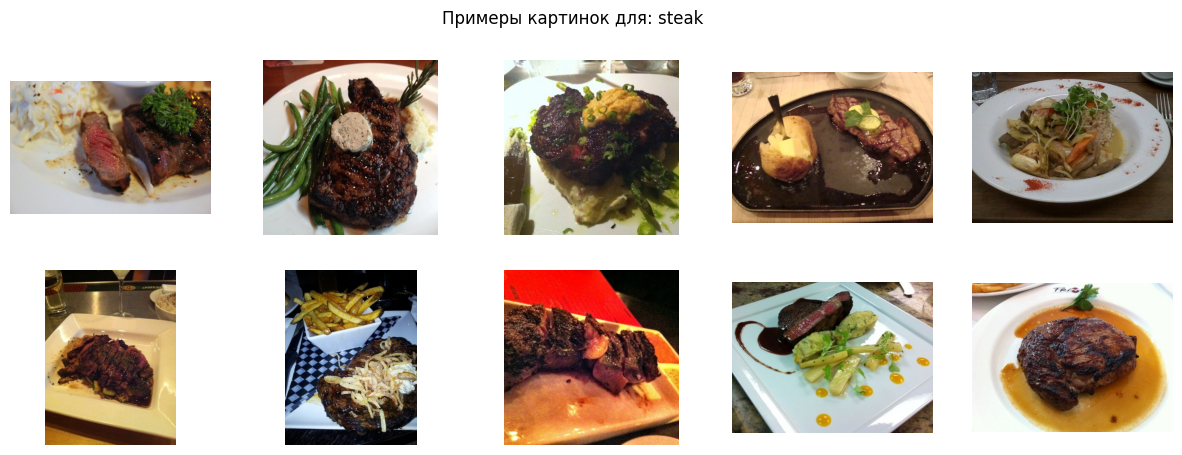

In [113]:
draw_img_food('steak')

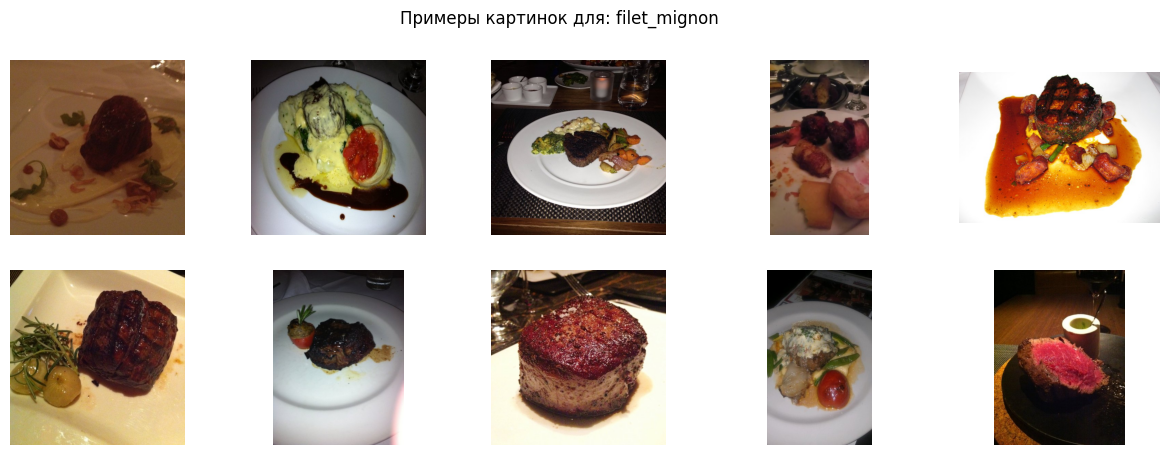

In [114]:
draw_img_food('filet_mignon')

Даже визуально блюда похожи

In [115]:
matrix[label2id['apple_pie']]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,
         0,   0,   0,   3, 167,   1,   0,   0,   0,   0,   0,   1,   0,
         6,   0,  18,   1,   0,   0,   1,   0,   2,   1,   0,   0,   0,
         7,   0,   2,   4,   2,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   1,   0,   0,   0,   0,   0,   1,   0,   0,   4,   0,   0,
         0,   0,   2,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,
         1,   2,   1,   0,   0,   1,   2,   0,   3,   0,   3,   0,   2,
         0,   0,   0,   5,   4,   0,   0,   0,   0,   0])

In [117]:
id2label[np.where(matrix[label2id['apple_pie']]==18)[0][0]]

'bread_pudding'

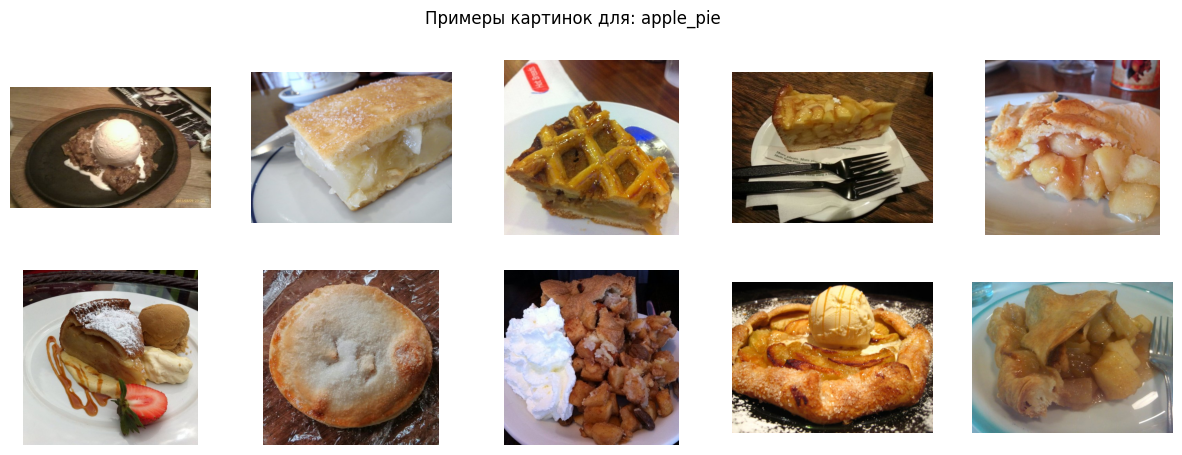

In [123]:
draw_img_food('apple_pie')

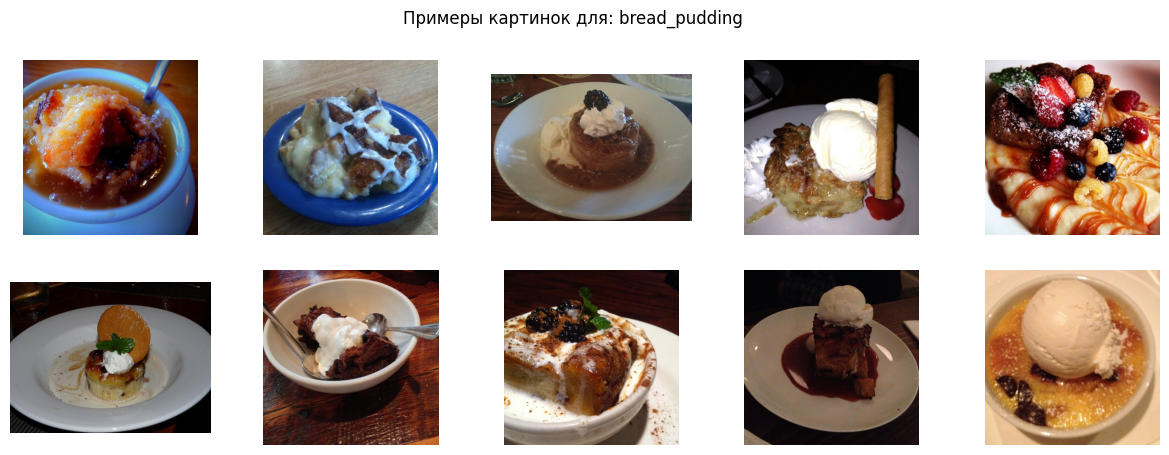

In [126]:
draw_img_food('bread_pudding')

Также apple_pie и bread_pudding очень похожи между собой 

Выводы: Низкая точность по классам обусловлена что некоторые классы похожи между собой. 
Как решение - это объединение классов (общение с заказчиком), удаление класса. Из техники можно попробовать 
Mixup для loss, Pseudolabling (удаление картинок с низкими скорами по некоторым классам и заново обучение).